## **Classification using Neural Networks**
In this notebook, we demonstrate how neural networks can learn complex classification patterns by focusing on the task of classifying spiral data.

# Preliminaries
We start with calling some useful libraries for mathematical opeartions (numpy, math), visualization (matpoltlib), and most importantly, neural networks (torch).

In [101]:
import random
import torch
import numpy as np
from torch import nn, optim
import math
from IPython import display
import matplotlib.pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

First, we define the following functions for simplifying the visualization

In [102]:
def plot_model(X, y, model):
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float().to(device)
        Z = model(data).detach()
    Z = np.argmax(Z.cpu(), axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X.cpu(), y.cpu())


In [103]:
def plot_data(X, y, d=0, auto=False, zoom=1):
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)

# Data Generation
Next, we generate the data.
We consider two-dimensional data samples divided to $C=3$ different classes. Here the data from the $c$th class, $c\in \{0,1,2\}$, is generated via:
$${\bf y}_c[i] = i\cdot \left(\begin{array}{c} \sin(\frac{2\pi}{C}(2i+c)+ \mathcal{N}(0, \sigma^2)) \\ \cos(\frac{2\pi}{C}(2i+c)+ \mathcal{N}(0, \sigma^2) ) \end{array}\right) .$$

To understand how this data looks like, lets generate some samples:

In [116]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
N = 1000  # num_samples_per_class
D = 2  # dimensions
C = 3  # num_classes
H = 100  # num_hidden_units


X = torch.zeros(N * C, D).to(device)
y = torch.zeros(N * C, dtype=torch.long).to(device)
for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N)
    # When c = 0 and t = 0: start of linspace
    # When c = 0 and t = 1: end of linpace
    # This inner_var is for the formula inside sin() and cos() like sin(inner_var) and cos(inner_Var)
    inner_var = torch.linspace(
        # When t = 0
        (2 * math.pi / C) * (c),
        # When t = 1
        (2 * math.pi / C) * (2 + c),
        N
    ) + torch.randn(N) * 0.3  # add some noise

    for ix in range(N * c, N * (c + 1)):
        X[ix] = t[index] * torch.FloatTensor((
            math.sin(inner_var[index]), math.cos(inner_var[index])
        ))
        y[ix] = c
        index += 1

# Permute the data randomly
p = np.random.permutation(3000)
X = X[p,:]
y = y[p]

print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

Shapes:
X: (3000, 2)
y: (3000,)


We have generated $1000$ samples from each label, i.e., a total of $T=3000$ data samples. Let's see what this data looks like:

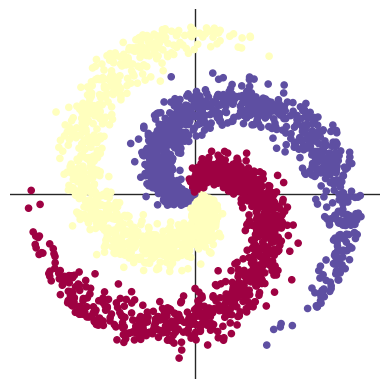

In [117]:
# visualise the data
plot_data(X.cpu(),y.cpu())

# Training Function
Now that we have generated data, we can train a parameterized model to carry out classification. In principle, this process would require defining a loss function for each model, computing gradients, backpropagating errors, and updating parameters manually. Fortunately, PyTorch provides robust tools that handle these steps for us. Our task is simply to choose a loss function, select an optimizer, and rely on the built-in backward() and step() methods to perform gradient computation and parameter updates.

Since this is a classification task, we use the cross-entropy loss. For optimization, we select the Adam optimizer with a learning rate of $\mu=10^{-3}$.

The training loop consists of the following steps:


1.   **Forward path** - Compute the model’s output for each batch, then calculate the loss and generate predictions (obtained using the $\arg\max$ of the model output).
2.   **Backward path** - Compute gradients using (*backward*) and update the model’s parameters with the optimizer (*step*) function.

**Note**: PyTocrh built in *CrossEntropyLoss()* criterion already applies the softmax transformation internally, which means the model output layer should not include a separate softmax activation.



In [ ]:
def train_model(TrainInput, TrainLabel, ValidInput, ValidLabel, model):
    learning_rate = 1e-3
    minibatch_size = 500

    # nn package also has different loss functions.
    # we use cross entropy loss for our classification task
    criterion = torch.nn.CrossEntropyLoss()

    # we use the optim package to apply
    # SGD for our parameter updates
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # built-in L2
    # Adam for our parameter updates
    # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # built-in L2

    train_acc, valid_acc = [], []
    epochs = []

    # Training
    for t in range(1000):
        # Divide data into mini batches
        p = np.random.permutation(len(TrainInput))
        TrainInput = TrainInput[p]
        TrainLabel = TrainLabel[p]
        for i in range(0, TrainInput.shape[0], minibatch_size):
          # Feed forward to get the logits
          y_pred = model(TrainInput[i:i+minibatch_size])

          # Compute the training loss and accuracy
          loss = criterion(y_pred, TrainLabel[i:i+minibatch_size])

          # zero the gradients before running
          # the backward pass.
          optimizer.zero_grad()

          # Backward pass to compute the gradient
          # of loss w.r.t our learnable params.
          loss.backward()

          # Update params
          optimizer.step()

        # Compute training accuracy
        score, predicted = torch.max(model(TrainInput), 1)
        acc = (TrainLabel == predicted).sum().float() / len(TrainLabel)


        # Compute the validation accuracy
        _, predicted = torch.max(model(ValidInput), 1)
        Validacc = (ValidLabel == predicted).sum().float() / len(ValidLabel)

        print("[EPOCH]: %i, [LOSS]: %.6f, [TRAIN ACCURACY]: %.3f, [VALID ACCURACY]: %.3f" % (t, loss.item(), acc, Validacc))
        display.clear_output(wait=True)


        # Save error on each epoch
        epochs.append(t)
        train_acc.append(acc.cpu())
        valid_acc.append(Validacc.cpu())

    # plotting
    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()


# Linear Model
The first model we train is a linear classifier. Recall that, because we use the cross-entropy loss module during training, the classifier implicitly includes a softmax output layer. 

To highlight the impact of non-linear activations something we will compare against when introducing a neural network later, we express our linear model as two consecutive linear layers. Therefore, the original $2\times 3$ affine mapping is factored into a $2\times 100$ mapping followed by $100\times 3$ mapping.

Again, PyTorch provides a very simple interface to form a multi-layered model, using the *Sequential()* module.


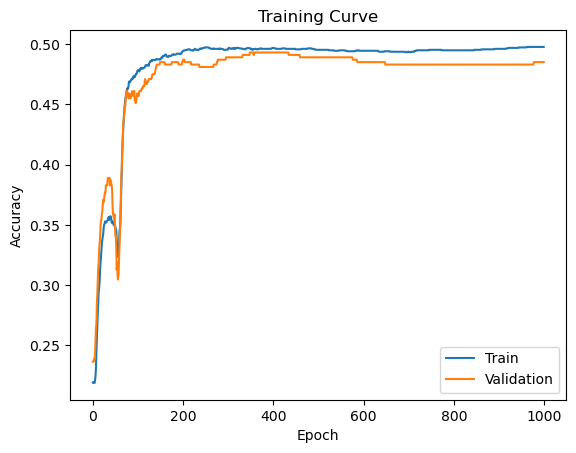

In [124]:
# each Linear module has a weight and bias
model = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C)
).to(device)

# train model using data
train_model(X[:2500,:], y[:2500],X[2501:,:], y[2501:], model)

Having trained the model, we note that the restriction to use linear models left us with a division of the two-dimensional space which is incapable of capturing the spiral form of the data. 

In particular, we achieve around $50\%$ accuracy.

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=3, bias=True)
)


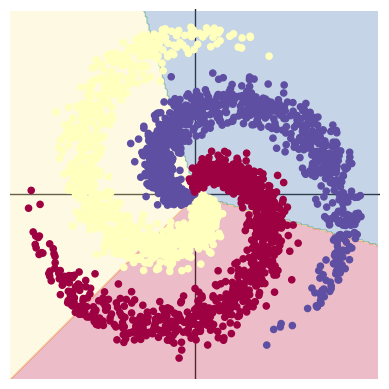

In [125]:
# Plot trained model
print(model)
plot_model(X, y, model)

# Neural Network
Next, we implement a neural network, by adding a non-linear ReLU activation between the affine layer. 

So we have a network of the form:
$2\times 100$ -- ReLU -- $100 \times 3$ -- Softmax.

Let's train this model

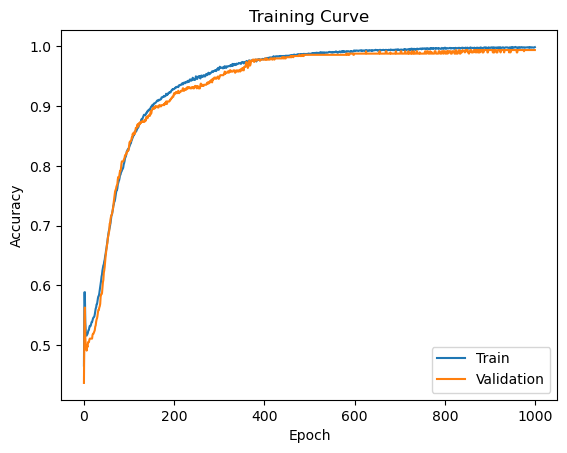

In [131]:

model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, C)
).to(device)

# train model using data
train_model(X[:2500,:], y[:2500],X[2501:,:], y[2501:], model)

The non-linearity of the neural network allows us to reach accuracy of $\sim 99\%$. The division of the two-dimensional space illustrated next demonstrates its ability to capture complex classification tasks.

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=3, bias=True)
)


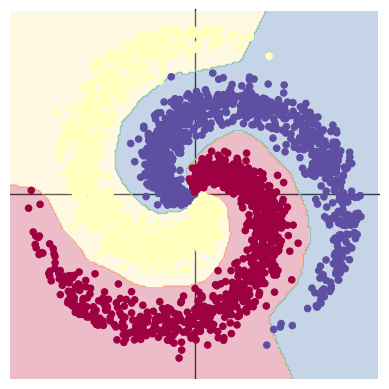

In [132]:
# Plot trained model
print(model)
plot_model(X, y, model)